# Statistical Properties of Limit Order Books

This notebook focuses on observing some fundamental empirical facts of Limit Order Book. Basic statistical properties of limit order books, which can be observed from real data (intraday) are studied.

The data is obtained from [TAQ data NYSE](https://www.nyse.com/market-data/historical/taq-integrated-feed) which contains data of all trade, depth of book, stock summary, order imbalance of all stocks traded on NYSE.

Information about AAPL stock on 03.03.2020 is used for the observation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
import time
import datetime

## 1. Data Importing and Cleaning

In [3]:
df = pd.read_csv("aapl_ibf.csv", header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3,5187,AAPL,9,55,Q,C,100.0,298.81,0,0.0,N,.0001,1
1,34,5189,00:21:39.955956224,AAPL,1,P,~,NaN,NaN,NaN,NaN,NaN,~,P
2,34,5502,03:58:00.001130752,AAPL,2,D,~,NaN,NaN,NaN,NaN,NaN,~,P
3,34,8330,07:00:00.016579072,AAPL,3,E,~,NaN,NaN,NaN,NaN,NaN,~,E
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B,,0.0,NaN,NaN,NaN


Here the 0th column shows the MsgType of the event.

Extracting add order msgs (MsgType:100)

In [5]:
add_ord_df = df[df[0]==100]
add_ord_df.columns = ['msgType', 'seqNo', 'time', 'sym', 'symSeqNo', 'ordId', 'price', 'volume', 'side', 'nine', 'ten', 'eleven', 'twelve', 'thirteen']

In [6]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side,nine,ten,eleven,twelve,thirteen
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B,,0.0,NaN,NaN,NaN
5,100,9199,07:25:12.713550336,AAPL,5,15481162373795648,302,1000.0,S,,0.0,NaN,NaN,NaN
11,100,12849,08:01:26.327212800,AAPL,11,15481162373804873,300.8,875.0,B,,0.0,NaN,NaN,NaN
17,100,13648,08:06:46.675132672,AAPL,17,15481162373806079,300,35.0,S,,0.0,NaN,NaN,NaN
19,100,16448,08:25:56.033052416,AAPL,19,15481162373809085,302.83,100.0,S,,0.0,NaN,NaN,NaN


Removing columns 9 - 13.

In [7]:
add_ord_df.drop(['nine', 'ten', 'eleven', 'twelve', 'thirteen'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B
5,100,9199,07:25:12.713550336,AAPL,5,15481162373795648,302,1000.0,S
11,100,12849,08:01:26.327212800,AAPL,11,15481162373804873,300.8,875.0,B
17,100,13648,08:06:46.675132672,AAPL,17,15481162373806079,300,35.0,S
19,100,16448,08:25:56.033052416,AAPL,19,15481162373809085,302.83,100.0,S


In [9]:
add_ord_df.dtypes

msgType       int64
seqNo         int64
time         object
sym          object
symSeqNo      int64
ordId        object
price        object
volume      float64
side         object
dtype: object

In [10]:
def strTons(string):
    ts = string.split('.')
    hms = ts[0].split(':')
    ns = ts[1]
    return pd.Timestamp(2020, 3, 3, int(hms[0]), int(hms[1]), int(hms[2]), int(ns[:3])).value // 1000000

Converting time from the format 'hh:mm:ss.nnnnnnnnn' to the number of milliseconds passed from the start of day.

In [11]:
arr_t_b = add_ord_df[add_ord_df['side']=='B']['time'].apply(func=strTons)
arr_t_s = add_ord_df[add_ord_df['side']=='S']['time'].apply(func=strTons)

## 2. Time of arrival of orders

In [12]:
start_time = strTons('09:30:00.000000000')
end_time = strTons('16:00:00.000000000')

In [13]:
arr_t_b = arr_t_b[arr_t_b > start_time]
arr_t_b = arr_t_b[arr_t_b < end_time]

arr_t_s = arr_t_s[arr_t_s > start_time]
arr_t_s = arr_t_s[arr_t_s < end_time]

In [14]:
arr_t_b = arr_t_b - start_time
arr_t_s = arr_t_s - start_time

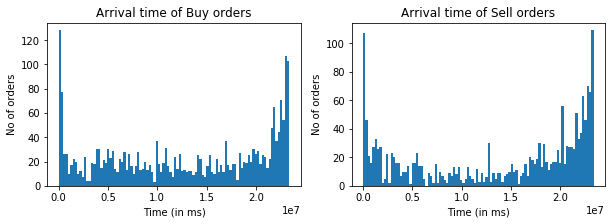

In [15]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(arr_t_b, bins=100)
ax1.set_xlabel("Time (in ms)")
ax1.set_title("Arrival time of Buy orders")
ax1.set_ylabel("No of orders")
ax2.hist(arr_t_s, bins=100)
ax2.set_title("Arrival time of Sell orders")
ax2.set_xlabel("Time (in ms)")
ax2.set_ylabel("No of orders")
plt.show()

It can be observed that it follows a U-shaped pattern which denotes, most stocks were traded at beginning and end of the day.

Calculating the Inter arrival time of the add new orders.

In [16]:
iat_b = (np.hstack((arr_t_b.iloc[1:], [0])) - np.array(arr_t_b))[:-1]
iat_s = (np.hstack((arr_t_s.iloc[1:], [0])) - np.array(arr_t_s))[:-1]

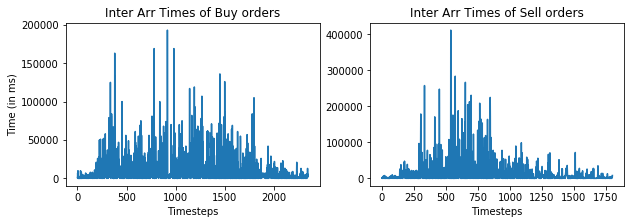

In [17]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(list(range(len(iat_b))), iat_b)
ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Time (in ms)")
ax1.set_title("Inter Arr Times of Buy orders")
ax2.plot(list(range(len(iat_s))), iat_s)
ax2.set_xlabel("Timesteps")
ax2.set_title("Inter Arr Times of Sell orders")
plt.show()

In [18]:
iat_b_count = dict()
for i in iat_b:
    if i in iat_b_count:
        iat_b_count[i] += 1
    else:
        iat_b_count[i] = 1

Fitting Empirical Distributions to the inter arrival times.

In [19]:
d = dict(sorted(iat_b_count.items()))
d_keys = np.array(list(d.keys()))
d_vals = np.array(list(d.values()))
mu = d_keys.mean()
std = d_keys.std()

In [20]:
e_b = ECDF(iat_b)
e_s = ECDF(iat_s)

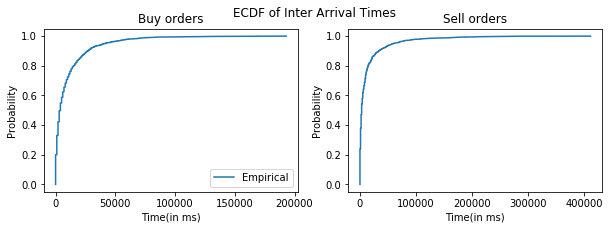

In [21]:
fig = plt.figure(figsize=(10, 3))
fig.suptitle("ECDF of Inter Arrival Times")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(e_b.x, e_b.y, label='Empirical')
ax1.set_title("Buy orders")
ax1.set_xlabel("Time(in ms)")
ax1.set_ylabel("Probability")
ax1.legend()

ax2.plot(e_s.x, e_s.y)
ax2.set_title("Sell orders")
ax2.set_xlabel("Time(in ms)")
ax2.set_ylabel("Probability")
plt.show()

In [22]:
# Exponential Distribution
lam = 1/mu
ex_pdf = []
ex_cdf = []
for i in d_keys:
    ex_pdf.append(lam*np.exp(-lam*i))
    ex_cdf.append(1-np.exp(-lam*i))

In [31]:
#Lognormal Distribution
ln_pdf = [0]
for i in range(1, len(d_keys)):
    t = (1/(std*np.sqrt(2*np.pi)))*np.exp(-(np.log(d_keys[i])-mu)**2/(2*std**2))
    ln_pdf.append(t)

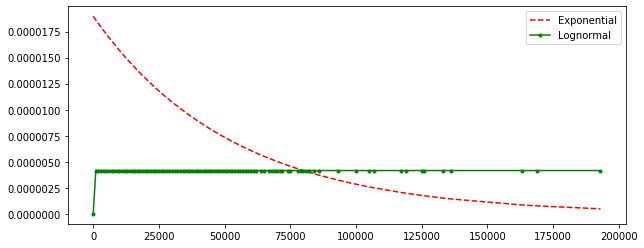

In [32]:
fig = plt.figure(figsize=(10, 4))
#plt.plot(d_keys, d_vals/d_vals.sum(), '-o', label="AAPL")
plt.plot(d_keys, ex_pdf, '--', color='r', label="Exponential")
plt.plot(d_keys, ln_pdf, '.-', color='g', label="Lognormal")
plt.legend()
plt.show()